<a href="https://colab.research.google.com/github/Jlokkerbol/masterclass/blob/main/spacy_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP with Python spaCy: analyzing restaurant reviews


_This work is licensed under a [Creative Commons BY-SA 4.0 License](http://creativecommons.org/licenses/by-sa/4.0/)_

<br><br><br><br>
__Daniel Kapitan__<br>
`e. d.kapitan@jads.nl`<br>
`w. https://kapitan.net`<br>



<img style="float: left" src="https://github.com/jads-nl/public-lectures/blob/main/logos/jads-gold-250x60.png?raw=true">

## The challenge: predict the restaurant review score with the review text

Thanks to [the people at analyticslab.nl](https://www.theanalyticslab.nl/about-us/) we will use a restaurant review dataset as our introduction to NLP with spaCy. The dataset contains nearly 370.000 reviews collected over an eight-year period, which they scraped from the original review website (I think it was iens.nl). We will follow along [their blogpost series](https://www.theanalyticslab.nl/nlpblogs_0_preparing_restaurant_review_data_for_nlp_and_predictive_modeling/), but replacing their R code with a workflow in Python spaCy.

In this notebook we compare different NLP techniques to show you how we get valuable information from unstructured text. Given the restaurant reviews, the challenge is whether these could be used to:
- Extract more structured information from the review texts without them having to read all the reviews one by one
- Extract actionable feedback to the restaurant staff
- Predict the review score using the text

Note that the original blog posts aimed to predict the next Michelin star. We will leave that as an extra challenge for you to try ...

The following tools and techniques will be demonstrated:

- How to setup a reproducible text pipeline in Python spaCy for text analysis;
- How to apply [topic modeling](http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf) as the primary tool to extract information from the review texts, to be combined and used in predictive modeling techniques to end up with our predictions
 

## Data preparation

Before we delve into the analytical side of things, we need some prepared textual data. As all true data scientists know, proper data preparation takes most of your time and is most decisive for the quality of the analysis results you end up with. Since preparing textual data is another cup of tea compared to preparing structured numeric or categorical data, and our goal is to show you how to do text analytics, we also want to show you how we cleaned and prepared the data we gathered. Therefore, in this notebook we start with the data dump with all reviews and explore and prepare this data in a number of steps:

![](https://github.com/jads-nl/public-lectures/blob/main/nlp/text-preprocessing-pipeline.png?raw=true)

In [1]:
!pip install pendulum pyLDAvis
!pip install -U pandas

     |████████████████████████████████| 155 kB 4.7 MB/s 
     |████████████████████████████████| 1.7 MB 49.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 489 kB 55.6 MB/s 
     |████████████████████████████████| 11.3 MB 33.0 MB/s 
     |████████████████████████████████| 15.7 MB 50.7 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=7c42f358b211b1fedfa54ccb8f768397ad4f504e44cc5359b48bb202e4bfc11d
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling p

In [1]:
import pyLDAvis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packa

In [2]:
import pandas as pd
import pendulum

raw_reviews = pd.read_parquet("https://github.com/jads-nl/public-lectures/blob/main/nlp/data/dutch-restaurant-reviews-per-year/reviewYear%3D2019/058d741d776d45f18e0ccc51f71173dc.parquet?raw=true")
raw_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47048 entries, 0 to 47047
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   restoId              47048 non-null  int64  
 1   restoName            47048 non-null  object 
 2   tags                 43857 non-null  object 
 3   address              47048 non-null  object 
 4   scoreTotal           46927 non-null  float64
 5   avgPrice             46461 non-null  object 
 6   numReviews           47048 non-null  int64  
 7   scoreFood            46927 non-null  float64
 8   scoreService         46927 non-null  float64
 9   scoreDecor           46951 non-null  float64
 10  review_id            47048 non-null  float64
 11  numreviews2          47048 non-null  float64
 12  valueForPriceScore   46582 non-null  object 
 13  noiseLevelScore      46610 non-null  object 
 14  waitingTimeScore     46610 non-null  object 
 15  reviewerId           47048 non-null 

Let's look at some `reviewText`s.

In [3]:
for review in raw_reviews.reviewText.head().to_list():
    print(review + "\n")

Een 5 gangen diner gegeten met bijbehorende wijnen. Elke gang was weer een feestje. Porties precies goed. Goedkoop is het niet. Incl aperitiefje en koffie met amaretto bijna 200 euro voor 2 personen.

Heerlijk gegeten met mooie wijnen er bij. Lief personeel, je wordt goed verwend. Komen zeker terug

V

Verassend en zeer  smaakvol bereid. .
4 Gangen gehad en allemaal uitstekend !

- Recensie is momenteel in behandeling -



To get a better understanding of our data, let's check the most frequent, identical review texts:

In [4]:
raw_reviews.reviewText.value_counts(normalize=True).head(20).map(lambda x: '{:,.3f}'.format(x*1))

- Recensie is momenteel in behandeling -      0.030
Heerlijk gegeten!                             0.003
Heerlijk gegeten                              0.002
Heerlijk gegeten.                             0.001
Top                                           0.001
Lekker gegeten                                0.001
Prima                                         0.000
Top!                                          0.000
Prima gegeten!                                0.000
Heerlijk gegeten!!                            0.000
Lekker gegeten.                               0.000
Weer heerlijk gegeten!                        0.000
Prima restaurant                              0.000
Zoals altijd weer heerlijk gegeten            0.000
Top restaurant!                               0.000
Heerlijk gegeten en vriendelijke bediening    0.000
Lekker gegeten!                               0.000
Good                                          0.000
Heerlijk eten!                                0.000
Geen        

Ok, several things to solve here:

- Another 0,4% has the value '- Recensie is momenteel in behandeling -' (In English: The review is currently being processed) and therefore the actual review text is not published yet. Similar to empty reviews, we can delete these reviews.
- Several reviews seem very short and are not that helpful in trying to learn from the review text. Although this is very context dependent (when performing sentiment analysis, short reviews like 'Top!' (English: Top!), 'Prima' (Engish: Fine/OK) and 'Heerlijk gegeten' (En: Had a nice meal) might still have much value!) we will set a minimum length to reviews.

Note that that reviews containing no text have already been removed from the original dataset.

### Simple filtering on text length

In [5]:
def validate_review(review):
    if review == '- Recensie is momenteel in behandeling -' or len(review) < 4:
        return False
    else:
        return True
    

reviews = raw_reviews.loc[:, ['restoId', 'reviewerId', 'review_id', 'reviewerFame', 'reviewerNumReviews', 'reviewText']].copy()
reviews['is_valid'] = reviews.reviewText.apply(validate_review)
reviews[reviews.is_valid=="False"]['reviewText'].value_counts(normalize=False).head(20)

Series([], Name: reviewText, dtype: int64)

In [6]:
reviews.describe()

,restoId,reviewerId,review_id,reviewerNumReviews
count,47048.000000,4.704800e+04,47048.000000,47048.000000
mean,277249.422080,1.286959e+08,14.168743,5.205343
std,64179.208137,1.504975e+07,20.663848,16.414192
min,219267.000000,2.370178e+06,1.000000,0.000000
25%,236601.000000,1.128674e+08,3.000000,1.000000
50%,250933.000000,1.273329e+08,8.000000,2.000000
75%,290551.000000,1.465682e+08,16.000000,4.000000
max,467925.000000,1.518483e+08,200.000000,535.000000


In [7]:
reviews.head(10)

,restoId,reviewerId,review_id,reviewerFame,reviewerNumReviews,reviewText,is_valid
0,326635,103983811.0,1.0,Meesterproever,19.0,Een 5 gangen diner gegeten met bijbehorende wi...,True
1,326635,120439569.0,2.0,Fijnproever,2.0,Heerlijk gegeten met mooie wijnen er bij. Lief...,True
2,427377,111554807.0,1.0,Expertproever,9.0,V,False
3,427377,147789559.0,2.0,Proever,1.0,Verassend en zeer smaakvol bereid. .\n4 Gange...,True
4,245213,112221413.0,1.0,Meesterproever,27.0,- Recensie is momenteel in behandeling -,False
5,245213,147350385.0,2.0,Proever,1.0,Wat een super restaurant is de baai! We hebben...,True
6,245213,147345417.0,3.0,Proever,1.0,"Heerlijk gegeten bij dit restaurant, de servic...",True
7,245213,147268729.0,4.0,Proever,1.0,Vorige week met zn allen daar prima gegeten. \...,True
8,245213,112869693.0,5.0,Proever,2.0,gisteren weer eens naar de baai geweest.\nde z...,True
9,245213,111690915.0,6.0,Expertproever,9.0,"Een aanrader voor de buurt, supper vers en le...",True


So that looks OK, we can safely delete `is_valid == 0` reviews later. Let's do some more data prep.

### Parse localized datestrings with `pendulum`

In [8]:
pendulum.set_locale('nl')
pendulum.date(2021, 2, 12).format('D MMM YYYY')  # example

'12 feb. 2021'

In [9]:
reviews.head(10)

,restoId,reviewerId,review_id,reviewerFame,reviewerNumReviews,reviewText,is_valid
0,326635,103983811.0,1.0,Meesterproever,19.0,Een 5 gangen diner gegeten met bijbehorende wi...,True
1,326635,120439569.0,2.0,Fijnproever,2.0,Heerlijk gegeten met mooie wijnen er bij. Lief...,True
2,427377,111554807.0,1.0,Expertproever,9.0,V,False
3,427377,147789559.0,2.0,Proever,1.0,Verassend en zeer smaakvol bereid. .\n4 Gange...,True
4,245213,112221413.0,1.0,Meesterproever,27.0,- Recensie is momenteel in behandeling -,False
5,245213,147350385.0,2.0,Proever,1.0,Wat een super restaurant is de baai! We hebben...,True
6,245213,147345417.0,3.0,Proever,1.0,"Heerlijk gegeten bij dit restaurant, de servic...",True
7,245213,147268729.0,4.0,Proever,1.0,Vorige week met zn allen daar prima gegeten. \...,True
8,245213,112869693.0,5.0,Proever,2.0,gisteren weer eens naar de baai geweest.\nde z...,True
9,245213,111690915.0,6.0,Expertproever,9.0,"Een aanrader voor de buurt, supper vers en le...",True


In [10]:
raw_reviews.head(10)

,restoId,restoName,tags,address,scoreTotal,avgPrice,numReviews,scoreFood,scoreService,scoreDecor,review_id,numreviews2,valueForPriceScore,noiseLevelScore,waitingTimeScore,reviewerId,reviewerFame,reviewerNumReviews,reviewDate,reviewScoreOverall,reviewScoreFood,reviewScoreService,reviewScoreAmbiance,reviewText
0,326635,Winehouse Somm,INTERNATIONAAL|INSIDER|BISTRONOMIQUE|GAULT&MIL...,Baffinstraat 1 1057 SV Amsterdam Nederland,9.4, 40,38,9.7,9.1,9.2,1.0,16.0,Gunstig,Precies goed,Kort,103983811.0,Meesterproever,19.0,9 mrt. 2019,9.0,10.0,8.0,8.0,Een 5 gangen diner gegeten met bijbehorende wi...
1,326635,Winehouse Somm,INTERNATIONAAL|INSIDER|BISTRONOMIQUE|GAULT&MIL...,Baffinstraat 1 1057 SV Amsterdam Nederland,9.4, 40,38,9.7,9.1,9.2,2.0,16.0,Gunstig,Precies goed,Kort,120439569.0,Fijnproever,2.0,1 mrt. 2019,10.0,10.0,10.0,10.0,Heerlijk gegeten met mooie wijnen er bij. Lief...
2,427377,De Herberg van Anderen,None,Nijend 2 9465 TR Anderen Nederland,8.7, 35,7,8.8,8.8,8.3,1.0,7.0,Gunstig,Rustig,Kort,111554807.0,Expertproever,9.0,3 mrt. 2019,7.0,6.0,8.0,8.0,V
3,427377,De Herberg van Anderen,None,Nijend 2 9465 TR Anderen Nederland,8.7, 35,7,8.8,8.8,8.3,2.0,7.0,Gunstig,Rustig,Kort,147789559.0,Proever,1.0,28 jan. 2019,9.5,10.0,10.0,8.0,Verassend en zeer smaakvol bereid. .\n4 Gange...
4,245213,De Baai Stadsstrand,INTERNATIONAAL|ZAKENLUNCH|AAN HET WATER|GLUTEN...,Weg naar Parkwijk 3541 Utrecht Nederland,8.6, 26,53,8.7,8.3,8.5,1.0,47.0,Gunstig,Precies goed,Redelijk,112221413.0,Meesterproever,27.0,15 mrt. 2019,8.5,8.0,8.0,10.0,- Recensie is momenteel in behandeling -
5,245213,De Baai Stadsstrand,INTERNATIONAAL|ZAKENLUNCH|AAN HET WATER|GLUTEN...,Weg naar Parkwijk 3541 Utrecht Nederland,8.6, 26,53,8.7,8.3,8.5,2.0,47.0,Gunstig,Precies goed,Redelijk,147350385.0,Proever,1.0,16 jan. 2019,10.0,10.0,10.0,10.0,Wat een super restaurant is de baai! We hebben...
6,245213,De Baai Stadsstrand,INTERNATIONAAL|ZAKENLUNCH|AAN HET WATER|GLUTEN...,Weg naar Parkwijk 3541 Utrecht Nederland,8.6, 26,53,8.7,8.3,8.5,3.0,47.0,Gunstig,Precies goed,Redelijk,147345417.0,Proever,1.0,16 jan. 2019,9.5,10.0,10.0,8.0,"Heerlijk gegeten bij dit restaurant, de servic..."
7,245213,De Baai Stadsstrand,INTERNATIONAAL|ZAKENLUNCH|AAN HET WATER|GLUTEN...,Weg naar Parkwijk 3541 Utrecht Nederland,8.6, 26,53,8.7,8.3,8.5,4.0,47.0,Gunstig,Precies goed,Redelijk,147268729.0,Proever,1.0,15 jan. 2019,9.0,10.0,8.0,8.0,Vorige week met zn allen daar prima gegeten. \...
8,245213,De Baai Stadsstrand,INTERNATIONAAL|ZAKENLUNCH|AAN HET WATER|GLUTEN...,Weg naar Parkwijk 3541 Utrecht Nederland,8.6, 26,53,8.7,8.3,8.5,5.0,47.0,Gunstig,Precies goed,Redelijk,112869693.0,Proever,2.0,13 jan. 2019,9.5,10.0,10.0,8.0,gisteren weer eens naar de baai geweest.\nde z...
9,245213,De Baai Stadsstrand,INTERNATIONAAL|ZAKENLUNCH|AAN HET WATER|GLUTEN...,Weg naar Parkwijk 3541 Utrecht Nederland,8.6, 26,53,8.7,8.3,8.5,6.0,47.0,Gunstig,Precies goed,Redelijk,111690915.0,Expertproever,9.0,11 jan. 2019,10.0,10.0,10.0,10.0,"Een aanrader voor de buurt, supper vers en le..."


In [11]:
def parse_date(date):
    return pendulum.from_format(date, fmt='D MMM YYYY', locale='nl')

reviews['reviewDate'] = raw_reviews.reviewDate.apply(parse_date).dt.date

In [12]:
reviews.reviewDate.head()

0    2019-03-09
1    2019-03-01
2    2019-03-03
3    2019-01-28
4    2019-03-15
Name: reviewDate, dtype: object

### Format numerical columns

In [13]:
raw_reviews["avgPrice"].describe()

count      46461
unique       103
top       â¬ 30
freq        5872
Name: avgPrice, dtype: object

In [14]:
raw_reviews["avgPrice"].unique()

array(['\x80 40', '\x80 35', '\x80 26', None, '\x80 33', '\x80 34',
       '\x80 25', '\x80 30', '\x80 31', '\x80 27', '\x80 32', '\x80 24',
       '\x80 13', '\x80 63', '\x80 29', '\x80 39', '\x80 23', '\x80 38',
       '\x80 45', 'â\x82¬ 43', 'â\x82¬ 39', 'â\x82¬ 37', 'â\x82¬ 35',
       'â\x82¬ 38', 'â\x82¬ 25', 'â\x82¬ 31', 'â\x82¬ 27', 'â\x82¬ 29',
       'â\x82¬ 23', 'â\x82¬ 21', 'â\x82¬ 13', 'â\x82¬ 45', 'â\x82¬ 40',
       'â\x82¬ 30', 'â\x82¬ 33', 'â\x82¬ 49', 'â\x82¬ 20', 'â\x82¬ 80',
       'â\x82¬ 28', 'â\x82¬ 60', 'â\x82¬ 47', 'â\x82¬ 46', 'â\x82¬ 18',
       'â\x82¬ 36', 'â\x82¬ 32', 'â\x82¬ 22', 'â\x82¬ 52', 'â\x82¬ 48',
       'â\x82¬ 15', 'â\x82¬ 26', 'â\x82¬ 55', 'â\x82¬ 70', 'â\x82¬ 12',
       'â\x82¬ 4', 'â\x82¬ 34', 'â\x82¬ 42', 'â\x82¬ 17', 'â\x82¬ 24',
       'â\x82¬ 44', 'â\x82¬ 51', 'â\x82¬ 56', 'â\x82¬ 41', 'â\x82¬ 50',
       'â\x82¬ 16', 'â\x82¬ 19', 'â\x82¬ 86', 'â\x82¬ 7', 'â\x82¬ 10',
       'â\x82¬ 78', 'â\x82¬ 11', 'â\x82¬ 58', 'â\x82¬ 83', 'â\x82¬ 68'

In [15]:
raw_reviews["avgPrice"].head(25)

0      40
1      40
2      35
3      35
4      26
5      26
6      26
7      26
8      26
9      26
10     26
11     26
12     26
13     26
14     26
15     26
16     35
17     35
18     35
19     35
20     35
21     35
22     35
23     35
24     35
Name: avgPrice, dtype: object

In [16]:
# avgPrice has whitespace and euro character
def clean_price(string):
    if string:
        return string.split(" ")[-1]
    else:
        return None


reviews["avgPrice"] = raw_reviews["avgPrice"].apply(clean_price)

In [17]:
reviews.head(20)

,restoId,reviewerId,review_id,reviewerFame,reviewerNumReviews,reviewText,is_valid,reviewDate,avgPrice
0,326635,103983811.0,1.0,Meesterproever,19.0,Een 5 gangen diner gegeten met bijbehorende wi...,True,2019-03-09,40
1,326635,120439569.0,2.0,Fijnproever,2.0,Heerlijk gegeten met mooie wijnen er bij. Lief...,True,2019-03-01,40
2,427377,111554807.0,1.0,Expertproever,9.0,V,False,2019-03-03,35
3,427377,147789559.0,2.0,Proever,1.0,Verassend en zeer smaakvol bereid. .\n4 Gange...,True,2019-01-28,35
4,245213,112221413.0,1.0,Meesterproever,27.0,- Recensie is momenteel in behandeling -,False,2019-03-15,26
5,245213,147350385.0,2.0,Proever,1.0,Wat een super restaurant is de baai! We hebben...,True,2019-01-16,26
6,245213,147345417.0,3.0,Proever,1.0,"Heerlijk gegeten bij dit restaurant, de servic...",True,2019-01-16,26
7,245213,147268729.0,4.0,Proever,1.0,Vorige week met zn allen daar prima gegeten. \...,True,2019-01-15,26
8,245213,112869693.0,5.0,Proever,2.0,gisteren weer eens naar de baai geweest.\nde z...,True,2019-01-13,26
9,245213,111690915.0,6.0,Expertproever,9.0,"Een aanrader voor de buurt, supper vers en le...",True,2019-01-11,26


In [18]:
reviews.describe()

,restoId,reviewerId,review_id,reviewerNumReviews
count,47048.000000,4.704800e+04,47048.000000,47048.000000
mean,277249.422080,1.286959e+08,14.168743,5.205343
std,64179.208137,1.504975e+07,20.663848,16.414192
min,219267.000000,2.370178e+06,1.000000,0.000000
25%,236601.000000,1.128674e+08,3.000000,1.000000
50%,250933.000000,1.273329e+08,8.000000,2.000000
75%,290551.000000,1.465682e+08,16.000000,4.000000
max,467925.000000,1.518483e+08,200.000000,535.000000


In [19]:
# turn categorical columns into ordinal values, lower is better
# note to Dutch audience: do you think the ordinal order is sensible and correct?
map_scores = {
    "waitingTimeScore": {
        "Hoog tempo": 1,
        "Kort": 2,
        "Redelijk": 3,
        "Kan beter": 4,
        "Lang": 5,
    },
    "valueForPriceScore": {
        "Erg gunstig": 1,
        "Gunstig": 2,
        "Redelijk": 3,
        "Precies goed": 4,
        "Kan beter": 5,
    },
    "noiseLevelScore": {
        "Erg rustig": 1,
        "Rustig": 2,
        "Precies goed": 3,
        "Rumoerig": 4,
    },
}

for col in map_scores.keys():
    reviews[col] = (
        raw_reviews[col].apply(lambda x: map_scores[col].get(x, None)).astype("Int64")
    )

In [20]:
# numerical columns have comma as decimal separator --> cast to floats
numerical_cols = [
    "scoreFood",
    "scoreService",
    "scoreDecor",
    "reviewScoreOverall",
    "scoreTotal",
]
for col in numerical_cols:
    reviews[col] = pd.to_numeric(raw_reviews[col])

In [21]:
reviews.head()

,restoId,reviewerId,review_id,reviewerFame,reviewerNumReviews,reviewText,is_valid,reviewDate,avgPrice,waitingTimeScore,valueForPriceScore,noiseLevelScore,scoreFood,scoreService,scoreDecor,reviewScoreOverall,scoreTotal
0,326635,103983811.0,1.0,Meesterproever,19.0,Een 5 gangen diner gegeten met bijbehorende wi...,True,2019-03-09,40,2,2,3,9.7,9.1,9.2,9.0,9.4
1,326635,120439569.0,2.0,Fijnproever,2.0,Heerlijk gegeten met mooie wijnen er bij. Lief...,True,2019-03-01,40,2,2,3,9.7,9.1,9.2,10.0,9.4
2,427377,111554807.0,1.0,Expertproever,9.0,V,False,2019-03-03,35,2,2,2,8.8,8.8,8.3,7.0,8.7
3,427377,147789559.0,2.0,Proever,1.0,Verassend en zeer smaakvol bereid. .\n4 Gange...,True,2019-01-28,35,2,2,2,8.8,8.8,8.3,9.5,8.7
4,245213,112221413.0,1.0,Meesterproever,27.0,- Recensie is momenteel in behandeling -,False,2019-03-15,26,3,2,3,8.7,8.3,8.5,8.5,8.6


### Exercise: perform exploratory data analysis

Prior to diving into NLP with spaCy, perform a EDA to explore possible correlations:
- reviewer type vs. given scores
- length of reviews vs. scores
- value-for-money vs. scores

Learning objective:
- Lest you forget to always do a short EDA, before getting lost in details ...

## Getting started with spaCy

To develop reproducible pipelines, we will follow the recommended workflow from spaCy.

![](https://spacy.io/pipeline-fde48da9b43661abcdf62ab70a546d71.svg)

When you call `nlp` on a text, spaCy first tokenizes the text to produce a `Doc` object. The `Doc` is then processed in several different steps – this is also referred to as the __processing pipeline__. The pipeline used by the [trained pipelines](https://spacy.io/models) typically include a tagger, a lemmatizer, a parser and an entity recognizer. Each pipeline component returns the processed `Doc`, which is then passed on to the next component.

The tokenizer is a “special” component and isn’t part of the regular pipeline. It also doesn’t show up in `nlp.pipe_names`. The reason is that there can only really be one tokenizer, and while all other pipeline components take a `Doc` and return it, the tokenizer takes a __string of text__ and turns it into a `Doc`. You can still customize the tokenizer, though. `nlp.tokenizer` is writable, so you can either create your own [`Tokenizer` class from scratch](https://spacy.io/usage/linguistic-features#native-tokenizers), or even replace it with an [entirely custom function](https://spacy.io/usage/linguistic-features#custom-tokenizer).

We will use the large Dutch model which is 546 MB in size. The download command needs to be run once on your system. You may want to restart your Jupyter Notebook kernel to ensure spaCy is loaded properly with the newly downloaded model.

In [34]:
!pip install --upgrade spacy

     |████████████████████████████████| 6.0 MB 5.5 MB/s 
     |████████████████████████████████| 10.1 MB 69.4 MB/s 
     |████████████████████████████████| 451 kB 36.4 MB/s 
     |████████████████████████████████| 628 kB 61.3 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 181 kB 60.0 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [35]:
!pip install -U spacy
!python -m spacy download nl_core_news_lg

     |████████████████████████████████| 572.6 MB 8.2 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('nl_core_news_lg')


In [36]:
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy


nlp = spacy.load("nl_core_news_lg")

We will show different options of tokenizing, see [this blog by Dataquest](https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/) for more details.

### Documents in spaCy

In [37]:
reviews.reviewText[8]

'gisteren weer eens naar de baai geweest.\nde zaak zat tot aan de nok vol, we hadden de laatse tafel kunnen reserveren.\nwe werden hartelijk ontvangen door de gedreven jongenman, die al jaren bij ze zaak werkt.\neerst een lekkere mosterd brie soep met gebakken spekjes.\ndaarna  een gebakken kabeljouw fillee met hollandaise saus.\nen als toetje pannacotta met stoofpeer en speculaas crumble.\necht alles was super lekker.\nsuper dat de baai zoiezo mag blijven tot eind 2020.'

In [38]:
# create spaCy doc from one of the reviews
example_doc = nlp(reviews.reviewText[8])

# Doc object has 51 attributes and methods
print(f"Methods and attributes of spaCy Doc object: {[attr for attr in dir(example_doc) if not '__' in attr]}")

Methods and attributes of spaCy Doc object: ['_', '_bulk_merge', '_context', '_get_array_attrs', '_realloc', '_vector', '_vector_norm', 'cats', 'char_span', 'copy', 'count_by', 'doc', 'ents', 'extend_tensor', 'from_array', 'from_bytes', 'from_dict', 'from_disk', 'from_docs', 'get_extension', 'get_lca_matrix', 'has_annotation', 'has_extension', 'has_unknown_spaces', 'has_vector', 'is_nered', 'is_parsed', 'is_sentenced', 'is_tagged', 'lang', 'lang_', 'mem', 'noun_chunks', 'noun_chunks_iterator', 'remove_extension', 'retokenize', 'sentiment', 'sents', 'set_ents', 'set_extension', 'similarity', 'spans', 'tensor', 'text', 'text_with_ws', 'to_array', 'to_bytes', 'to_dict', 'to_disk', 'to_json', 'to_utf8_array', 'user_data', 'user_hooks', 'user_span_hooks', 'user_token_hooks', 'vector', 'vector_norm', 'vocab']


In [45]:
for token in example_doc:
  print(token)

gisteren
weer
eens
naar
de
baai
geweest
.


de
zaak
zat
tot
aan
de
nok
vol
,
we
hadden
de
laatse
tafel
kunnen
reserveren
.


we
werden
hartelijk
ontvangen
door
de
gedreven
jongenman
,
die
al
jaren
bij
ze
zaak
werkt
.


eerst
een
lekkere
mosterd
brie
soep
met
gebakken
spekjes
.


daarna
 
een
gebakken
kabeljouw
fillee
met
hollandaise
saus
.


en
als
toetje
pannacotta
met
stoofpeer
en
speculaas
crumble
.


echt
alles
was
super
lekker
.


super
dat
de
baai
zoiezo
mag
blijven
tot
eind
2020
.


In [46]:
# visualize named entities
spacy.displacy.render(example_doc, style='ent', jupyter=True)

In [47]:
# visualize dependencies
spacy.displacy.render(example_doc, style='dep', jupyter=True)

### Tokens in spaCy

In [48]:
# example_doc holds all tokens
print(f"Length of example doc: {len(example_doc)}")

# which you can access as a list
print(f"First token example doc: {example_doc[0]}")

# each token is a spaCy Token object with 90 methods and attributes
token_attrs = [attr for attr in dir(example_doc[0]) if not '__' in attr]
print(f"Each token is a {type(example_doc[0])} with 90 attributes:")
print(token_attrs)

Length of example doc: 96
First token example doc: gisteren
Each token is a <class 'spacy.tokens.token.Token'> with 90 attributes:
['_', 'ancestors', 'check_flag', 'children', 'cluster', 'conjuncts', 'dep', 'dep_', 'doc', 'ent_id', 'ent_id_', 'ent_iob', 'ent_iob_', 'ent_kb_id', 'ent_kb_id_', 'ent_type', 'ent_type_', 'get_extension', 'has_dep', 'has_extension', 'has_head', 'has_morph', 'has_vector', 'head', 'i', 'idx', 'iob_strings', 'is_alpha', 'is_ancestor', 'is_ascii', 'is_bracket', 'is_currency', 'is_digit', 'is_left_punct', 'is_lower', 'is_oov', 'is_punct', 'is_quote', 'is_right_punct', 'is_sent_end', 'is_sent_start', 'is_space', 'is_stop', 'is_title', 'is_upper', 'lang', 'lang_', 'left_edge', 'lefts', 'lemma', 'lemma_', 'lex', 'lex_id', 'like_email', 'like_num', 'like_url', 'lower', 'lower_', 'morph', 'n_lefts', 'n_rights', 'nbor', 'norm', 'norm_', 'orth', 'orth_', 'pos', 'pos_', 'prefix', 'prefix_', 'prob', 'rank', 'remove_extension', 'right_edge', 'rights', 'sent', 'sent_start',

In [49]:
# let's view token attributes we want to use
pd.DataFrame(
    [
        (
            token.text,
            token.lower_,
            token.lemma_,
            token.shape_,
            token.is_alpha,
            token.is_stop,
            token.is_punct,
            token.tag_,
        )
        for token in example_doc
    ],
    columns=[
        "text",
        "lower_",
        "lemma_",
        "shape_",
        "is_alpha",
        "is_stop",
        "is_punct",
        "tag_",
    ],
)

,text,lower_,lemma_,shape_,is_alpha,is_stop,is_punct,tag_
0,gisteren,gisteren,gisteren,xxxx,True,False,False,BW
1,weer,weer,weer,xxxx,True,True,False,BW
2,eens,eens,eens,xxxx,True,True,False,BW
3,naar,naar,naar,xxxx,True,True,False,VZ|init
4,de,de,de,xx,True,True,False,LID|bep|stan|rest
...,...,...,...,...,...,...,...,...
91,blijven,blijven,blijven,xxxx,True,False,False,WW|inf|vrij|zonder
92,tot,tot,tot,xxx,True,True,False,VZ|init
93,eind,eind,eind,xxxx,True,False,False,N|soort|ev|basis|onz|stan
94,2020,2020,2020,dddd,False,False,False,TW|hoofd|vrij


### Simple tokenizer

In [50]:
def tokenize_simple(text):
    """Tokenizer returning lowercase tokens with no stop words, no punctuation and no words with encoding errors"""
    doc = nlp(text)
    return [token.lower_ for token in doc if not (token.is_stop or token.is_punct or ("\\" in token.lower_))]

tokenize_simple(reviews.reviewText[8])

['gisteren',
 'baai',
 '\n',
 'zaak',
 'zat',
 'nok',
 'vol',
 'laatse',
 'tafel',
 'reserveren',
 '\n',
 'hartelijk',
 'ontvangen',
 'gedreven',
 'jongenman',
 'jaren',
 'zaak',
 'werkt',
 '\n',
 'lekkere',
 'mosterd',
 'brie',
 'soep',
 'gebakken',
 'spekjes',
 '\n',
 ' ',
 'gebakken',
 'kabeljouw',
 'fillee',
 'hollandaise',
 'saus',
 '\n',
 'toetje',
 'pannacotta',
 'stoofpeer',
 'speculaas',
 'crumble',
 '\n',
 'echt',
 'super',
 'lekker',
 '\n',
 'super',
 'baai',
 'zoiezo',
 'blijven',
 'eind',
 '2020']

In [51]:
len(tokenize_simple(reviews.reviewText[8]))

49

### Using lemmas as tokens

In [52]:
reviews.reviewText[23]

'Voor zondag avond gereserveerd. Leuke vriendschappelijke ontvangst.\nVoorgerechten waren top. Eveneens het hoofdgerecht geprepareerd zoals verzocht. En alles fantastisch op smaak en mooi opgemaakt. Dessert zoals beloofd; smakelijk en fris.\nHier komen wij zeker terug!'

In [53]:
def tokenize_lemma(text):
    """Tokenizer returning lemmas with no stop words, no punctuation and no words with encoding errors"""
    doc = nlp(text)
    return [token.lemma_ for token in doc if not (token.is_stop or token.is_punct or ("\\" in token.lower_))]

tokenize_lemma(reviews.reviewText[23])

['zondag',
 'avond',
 'reserveren',
 'leuk',
 'vriendschappelijk',
 'ontvangst',
 '\n',
 'voorgerecht',
 'top.',
 'hoofdgerecht',
 'prepareren',
 'verzoeken',
 'fantastisch',
 'smaak',
 'mooi',
 'opmaken',
 'dessert',
 'beloven',
 'smakelijk',
 'fris',
 '\n',
 'komen',
 'terug']

### Exercises

#### Remove accents in the tokens such that `vóór` is tokenized as `voor` 

#### Explore association between overall review score and length of text

#### Extract ADJ-NOUN bigrams from the text

Imagine you are advising the owner of a restaurant who wants to mine the reviews to find specific improvement points. Assuming that ADJECTIVE - NOUN bigrams can provide useful input, for example 'oude servies', 'lange wachttijd', your task is to:
- Extract ADJ-NOUN bigrams for each review
- Find the most interesting bigrams for positive and negative reviews per restaurant

## Document-Term Matrix


### Unigrams and bag-of-words
Use `sklearn.feature_extraction.text.CountVectorizer` to create the DTM. Since this is a large and sparse matrix, this data is a [`scipy.sparse.spmatrix` object](https://docs.scipy.org/doc/scipy/reference/sparse.html) instead of a pandas dataframe. We will use the spaCy's `Defaults.stop_words`. Since creating the DTM for all reviews takes a long time, we will test it first with just 1,000 records

In [83]:
%%time
count_vectorizer = CountVectorizer(tokenizer=tokenize_simple, stop_words=nlp.Defaults.stop_words, ngram_range=(1,1))
count_vectorizer.fit_transform(reviews.reviewText[:1000])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['t', '’n'] not in stop_words.
  % sorted(inconsistent)


CPU times: user 14.4 s, sys: 64.6 ms, total: 14.5 s
Wall time: 14.5 s


That's an interesting warning. Let's look at the stopwords that we have used.

In [84]:
print(list(nlp.Defaults.stop_words))

['pp', 'daarop', 'moest', 'beter', 'enz', 'nooit', 'lang', 'evenwel', 'des', 'beiden', 'ff', 'dien', 'heb', 'moesten', 'alles', 'aangaangde', 'dikwijls', 'ikzelf', 'hoe', 'met', 'vandaan', 'ja', 'gij', 'bijvoorbeeld', 'eens', 'op', 'sinds', 'anders', 'precies', 'omstreeks', 'gegeven', 'nr', 'ons', 'voort', 'hij', 'ze', 'klaar', 'dezen', 'zo', 'weinig', 'er', 'der', 'alhoewel', 'inmiddels', '‘t', 'gauw', 'dezelfde', 'wilde', 'onder', 'prof', 'haar', 'spoedig', 'misschien', 'zoals', 'waar', 'deze', 'reeds', 'ander', 'pas', 'jou', 'wie', 'nu', 'liet', 'weldra', 'min', 'vrij', 'doorgaand', 'achterna', 'even', 'vanwege', "'t", 'tegen', 'hierbeneden', 'te', 'boven', 'meer', 'hen', 'afgelopen', 'voorop', 'binnen', 'ook', 'zonder', 'maar', 'mijn', 'idd', 'waren', 'welk', 'af', 'van', 'iets', 'publ', 'mogelijk', 'in', 'wiens', 'zo’n', 'zichzelf', 'zij', 'voordien', 'ongeveer', 'sommige', 'slechts', 'bovendien', 'hadden', 'nabij', 'aldus', 'toch', 'beide', 'vanaf', 'het', 'zelfde', 'vooraf', 'ne

So what happens here is:
- spaCy tokenizes, for example, the stop word `zo'n` into `[zo, ', n]`
- since we have chosen to remove punctuation we end up with `[zo, n]` as the tokens of the original stop word
- `zo` was already in the list of stop words, but `n` isn't which is what the warning is about

Adding those two fixes the warning, so now we can move on to actually calculate the most frequent words.

In [85]:
%%time
stop_words = nlp.Defaults.stop_words.update(['n', 't'])
count_vectorizer = CountVectorizer(tokenizer=tokenize_simple, stop_words=stop_words, ngram_range=(1,1))
bow = count_vectorizer.fit_transform(reviews.reviewText[:1000]) # just 1,000 reviews for demonstration

CPU times: user 10 s, sys: 24.6 ms, total: 10 s
Wall time: 10 s


In [86]:
bow.sum(axis=0).A1.transpose().ravel().shape

(3010,)

Let's inspect the most frequent unigrams.

In [87]:
unigrams = pd.Series(bow.sum(axis=0).A1.transpose().ravel(), index=count_vectorizer.get_feature_names())
unigrams.sort_values(ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


eten         375
bediening    328
\n           327
gegeten      305
heerlijk     288
            ... 
aanpak         1
ivol           1
italiaans      1
it             1
luchtiger      1
Length: 3010, dtype: int64

### TF-IDF
In the same vein, we could use the `TfidfVectorizer`. While we are at it, let's include bigrams, too.

In [97]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_simple, stop_words=stop_words, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(reviews.reviewText[:1000])

Let's see which words have the highest TF-IDF per document.

In [98]:
tfidf.A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [100]:
rare_bigrams = pd.Series([tfidf_vectorizer.get_feature_names()[i] for i in tfidf.A.argmax(axis=1)])
rare_bigrams.head(20)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


0               amaretto
1           goed verwend
2                      v
3                   \n 4
4              momenteel
5                  super
6        geweldige sfeer
7     carpaccio maaltijd
8                     \n
9                  \n ps
10             momenteel
11                 super
12       geweldige sfeer
13    carpaccio maaltijd
14                    \n
15                 \n ps
16             momenteel
17          almere haven
18              havenkom
19        bediening leuk
dtype: object

In [101]:
print(reviews.reviewText[0])

Een 5 gangen diner gegeten met bijbehorende wijnen. Elke gang was weer een feestje. Porties precies goed. Goedkoop is het niet. Incl aperitiefje en koffie met amaretto bijna 200 euro voor 2 personen.


We will use the document-term matrix, with either simple counts or with TF-IDF, later on in our classification pipeline.

## Topic modeling

### Combining DTM with LDA

The [sklearn example on topic modeling](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html?highlight=topic%20modeling) shows how to setup a pipeline for topic modeling. We will follow along with the same parameter settings and [use pyLDAvis](https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb) to visualize our results.

In [102]:
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn


pyLDAvis.enable_notebook()

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20

In [103]:
%%time
tfidf_vectorizer2 = TfidfVectorizer(
    max_df=0.95,
    min_df=2,
    max_features=n_features,
    tokenizer=tokenize_simple,
    stop_words=stop_words,
    strip_accents='unicode',
    ngram_range=(1, 2),
)
dtm_tfidf = tfidf_vectorizer2.fit_transform(reviews.reviewText[:n_samples])

CPU times: user 23.3 s, sys: 75.7 ms, total: 23.4 s
Wall time: 23.4 s


In [104]:
%%time
lda_tfidf = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
).fit(dtm_tfidf)

CPU times: user 1.55 s, sys: 12.7 ms, total: 1.56 s
Wall time: 1.56 s


In [105]:
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.070751 -0.049503       1        1  39.936402
9     -0.116971 -0.167740       2        1  31.371191
4      0.297384 -0.062777       3        1   5.318677
1     -0.046154  0.055691       4        1   4.492672
5     -0.024715  0.029173       5        1   3.382158
2     -0.022075  0.020842       6        1   3.338418
0     -0.002296  0.048779       7        1   3.148434
6     -0.003109  0.046808       8        1   3.118459
7     -0.005680  0.035683       9        1   3.093374
8     -0.005633  0.043044      10        1   2.800215, topic_info=                      Term       Freq      Total Category  logprob  loglift
723               recensie  45.000000  45.000000  Default  30.0000  30.0000
604  momenteel behandeling  45.000000  45.000000  Default  29.0000  29.0000
724     recensie momenteel  45.000000  45.000000  Default  28.0000  28.0000
603              momenteel  45.000000  45.000000  Default  27.0000  27.0000
113            behandeling  45.000000  45.000000  Default  26.0000  26.0000
..                     ...        ...        ...      ...      ...      ...
870             verhouding   0.315984   9.835669  Topic10  -6.3130   0.1374
955                 wijnen   0.284767  12.452144  Topic10  -6.4170  -0.2025
376                   goed   0.321793  61.535292  Topic10  -6.2948  -1.6780
782                  smaak   0.230508  14.667260  Topic10  -6.6284  -0.5776
391                  goede   0.239605  38.457686  Topic10  -6.5897  -1.5028

[472 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         1  0.539742             \n
0         2  0.421674             \n
0         4  0.016867             \n
0         9  0.016867             \n
11        2  0.831339   \n herhaling
...     ...       ...            ...
995       1  0.826208              €
996       7  0.560798              ❗
997       7  0.562509        ❗ ️zeer
998       7  0.562144          ️zeer
999       7  0.562284  ️zeer bevelen

[594 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 10, 5, 2, 6, 3, 1, 7, 8, 9])

### Second iteration topic model

The results from the topic model are not really useful: frequent occuring words are included in many topics, resulting in overlapping topics. Following the [approach from the Analytics Lab](https://www.theanalyticslab.nl/nlpblogs_1_identifying_topics_using_topic_-modeling_lda/) we will second topic model which uses a simple `CountVectorizer` including only words that occur in 5 or more documents. 

In [106]:
%%time
count_vectorizer2 = CountVectorizer(
    min_df=5,
    max_df=50,
    max_features=n_features,
    tokenizer=tokenize_lemma,
    stop_words=stop_words,
    strip_accents='unicode',
    ngram_range=(1, 2),
)
dtm_tf2 = count_vectorizer2.fit_transform(reviews.reviewText[:n_samples])

Streaming output truncated to the last 5000 lines.
niet
ze
moeten
zich
aan
de
prijslijst
houden
vind
ik
.


had
een
vriend
over
en
die
zei
t
is
koe
maar
ik
vind
je
besteld
en
daar
betaal
je
voor.je
zag
niet
wezenlijk
de
verschillen
tussen
een
grote
en
een
kleine
portie
.
heerlijk
eten
!
verse
ingredienten
,
goede
porties
.
ook
vegetarische
gerecht
was
zeer
smaakvol
.
   

tikkeltje
lawaaiig
,
maar
dat
zou
je
ook
levendig
kunnen
noemen
.
aanrader
!
goed
eten
,
voor
een
heel
redelijke
prijs
.
geen
onnodige
poeha
,
fratsen
of
andere
"
modieuze
onzin
"
;
gewoon
eerlijk
en
goed
eten
.
als
je
wel
eens
in
azie
in
een
familierestaurant
hebt
gegeten
,
dan
zul
je
dit
ook
kunnen
waarderen
....
prima
thaise
smaken
!
vriendelijk
personeel
maar
mist
wat
interactie
.
snel
geholpen
.
prijs/kwaliteit
is
prima
in
orde
.
we
hebben
hier
al
meerdere
keren
in
de
afgelopen
15
jaar
gegeten
en
altijd
constante
kwaliteit
.
gezellig
zitten
en
leuke
bediening
lekker
gegeten
bij
t
is
boven
.
weer
eens
wat
anders
.

In [107]:
%%time
lda_tf2 = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=42,
).fit(dtm_tf2)

CPU times: user 1.65 s, sys: 6.15 ms, total: 1.66 s
Wall time: 1.66 s


In [108]:
pyLDAvis.sklearn.prepare(lda_tf2, dtm_tf2, count_vectorizer2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.064416 -0.023986       1        1  34.844873
4     -0.041089  0.039704       2        1  14.395046
0     -0.049335 -0.062498       3        1   8.914608
5     -0.117205 -0.163645       4        1   8.667665
3      0.075674  0.158495       5        1   8.420318
1     -0.171642  0.183496       6        1   7.956562
6     -0.071006 -0.150276       7        1   5.170685
9      0.014308  0.075705       8        1   5.017568
2      0.260615 -0.041398       9        1   4.553140
8      0.035264 -0.015597      10        1   2.059535, topic_info=           Term       Freq      Total Category  logprob  loglift
700  prima eten  51.000000  51.000000  Default  30.0000  30.0000
83        actie  48.000000  48.000000  Default  29.0000  29.0000
485       keuze  52.000000  52.000000  Default  28.0000  28.0000
906        vlot  41.000000  41.000000  Default  27.0000  27.0000
362        glas  46.000000  46.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
737        rest   0.994006  17.229437  Topic10  -5.6533   1.0301
439        hoog   2.026396  38.133323  Topic10  -4.9410   0.9479
472        kant   0.989432  18.762331  Topic10  -5.6579   0.9402
53            5   0.994617  22.878272  Topic10  -5.6527   0.7471
51            4   1.036522  24.084103  Topic10  -5.6114   0.7370

[487 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
8         3  0.240445   \n gerecht
8         7  0.601113   \n gerecht
10        2  0.382471      \n goed
10        3  0.546387      \n goed
11        1  0.270923  \n heerlijk
...     ...       ...          ...
986       5  0.754472           zn
996       1  0.084360        zowel
996       4  0.590521        zowel
996       7  0.253080        zowel
999       7  0.833259        zweer

[859 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 1, 6, 4, 2, 7, 10, 3, 9])

Now that looks a lot better out-of-the-box already. Remember, like with t-sne and hierarchical clustering, LDA is a non-deterministic algorithm which will yield different results depending on the seed. Furthermore, there is no objective function that you can optimize, so it's up to you to decide what constitutes a good, i.e. useful topic model.

### Exercises

#### Improve the topic model

Play around and try to improve the topic model. You may use any of the following techniques:
- Remove frequent words by adding them to the set of stop words
- Use lemma's instead of plain tokens
- Try different `random_state`s

#### Calculate topic probabilities per review

Following the [approach of the Analytics Lab](https://www.theanalyticslab.nl/nlpblogs_3_use_topic_modeling_results_in_predictive_modeling/), calculate the topic probability per review over your chosen topic model. The topic probabilities should sum to 1.0. These topic probabilities will be used as input for the classification task.

## Classification challenge: predict detractors from text reviews

As a final exercise, combine all the different techniques we have covered so far to build a model that predicts the review score using the text. Specifically, we are interested in classifying [detractors](https://en.wikipedia.org/wiki/Net_Promoter), i.e. people that have given an overall score of 6 or lower. This is an imbalanced class problems, since only 7% of the overall reviews are detractors.

Percentage of detractors: 7.000000000000001%



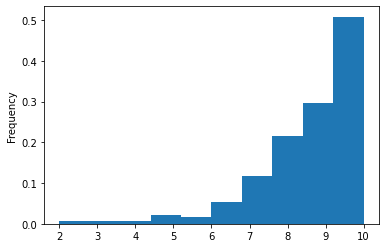

In [113]:
_ = reviews.reviewScoreOverall.value_counts(normalize=True)
print(f"Percentage of detractors: {_[_.index <= 6].sum().round(2)*100}%\n")
reviews.reviewScoreOverall.plot(kind='hist', density=True);

To make the challenge manageable, you can reduce the number of reviews included in your analysis by focusing on a particular year, or one particular restaurant (which has enough reviews).